In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import torch
import matplotlib.pyplot as plt

In [5]:
bm = xr.open_dataset("/home/kim/data/bedmap3/bedmap3.nc")

In [7]:
x_min = - 600_000
x_max = 400_000
y_min = - 1_400_000
y_max = - 400_000

bm_ross = bm.sel(
    x = slice(x_min, x_max), 
    y = slice(y_max, y_min))

In [9]:
bm_ross

<xarray.Dataset>
Dimensions:                 (x: 2000, y: 2000)
Coordinates:
  * x                       (x) float32 -5.998e+05 -5.992e+05 ... 3.998e+05
  * y                       (y) float32 -4.002e+05 -4.008e+05 ... -1.4e+06
Data variables:
    surface_topography      (y, x) float32 ...
    bed_uncertainty         (y, x) float32 ...
    bed_topography          (y, x) float32 ...
    mask                    (y, x) float32 ...
    ice_thickness           (y, x) float32 ...
    thickness_survey_count  (y, x) float32 ...
    thickness_uncertainty   (y, x) float32 ...
    mapping                 <U19 ...
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

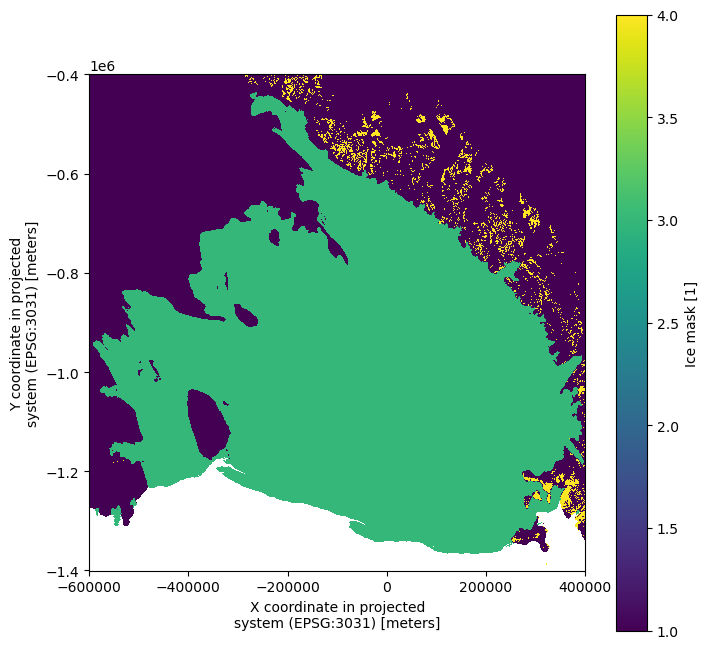

In [13]:
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using pcolormesh
bm_ross.mask.plot.pcolormesh(ax = ax, cmap = "viridis")

ax.set_aspect("equal")
plt.show()

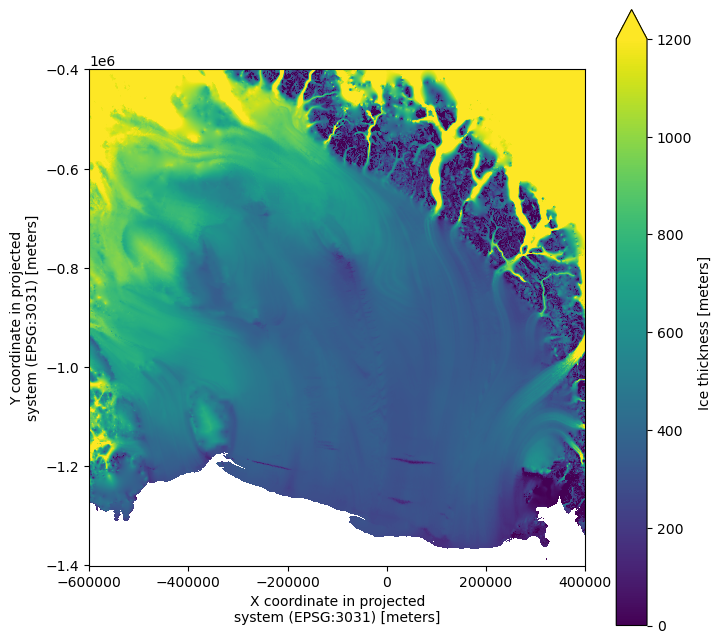

In [10]:
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using pcolormesh
bm_ross.ice_thickness.plot.pcolormesh(ax = ax, cmap = "viridis", vmin = 0, vmax = 1200)

ax.set_aspect("equal")
plt.show()

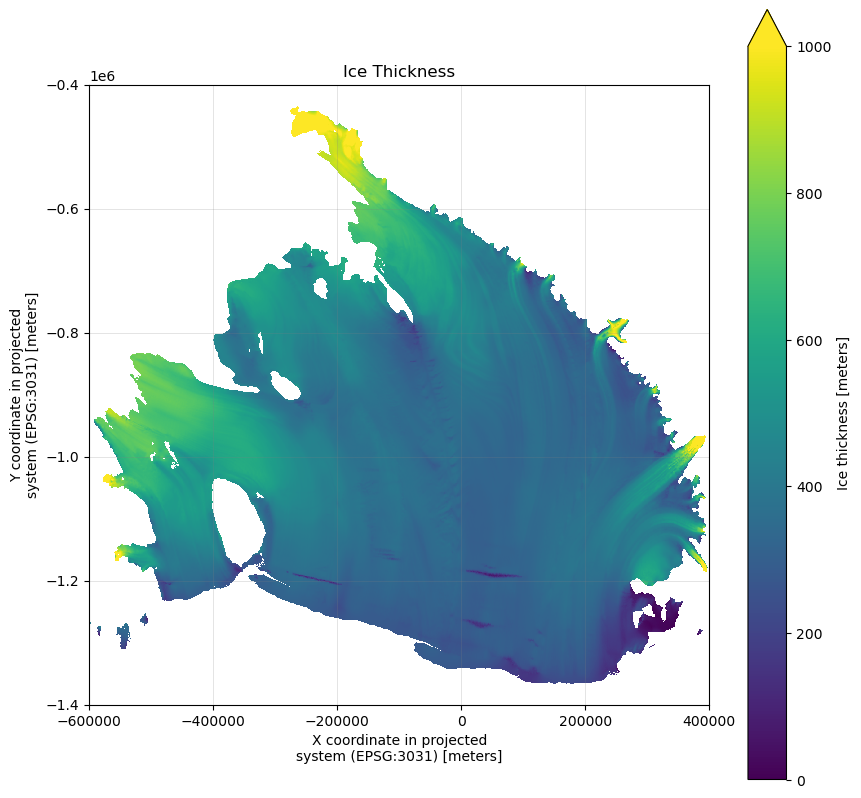

In [21]:
fig, ax = plt.subplots(figsize = (10, 10))

# Plot only the subset where mask == 3
bm_ross.ice_thickness.where(bm_ross.mask == 3).plot.pcolormesh(
    ax = ax, cmap = "viridis", vmin = 0, vmax = 1000)

ax.set_title("Ice Thickness")
ax.grid(True, which = "both", color = "grey", alpha = 0.3, linewidth = 0.5)
ax.set_aspect("equal")
plt.savefig("figures/ice_thickness_bedmap3.png", dpi = 300, bbox_inches = "tight")
plt.show()

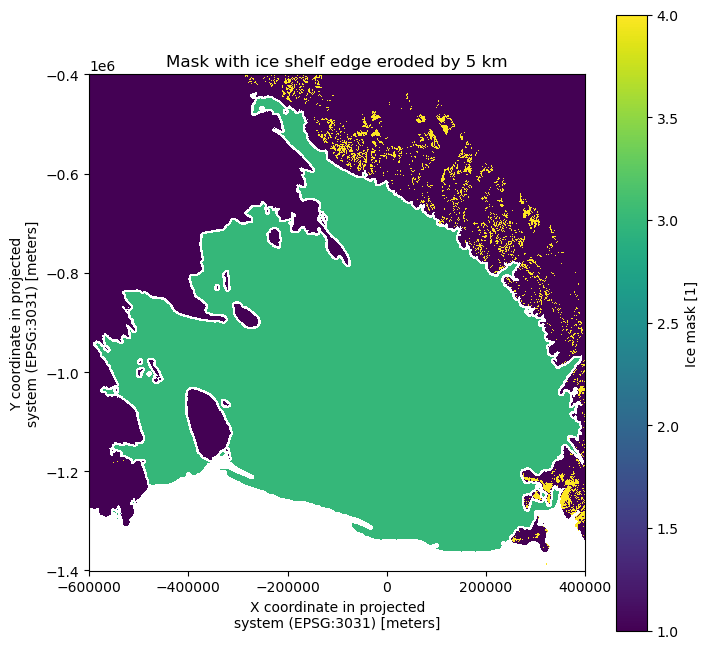

In [32]:
import numpy as np
import xarray as xr
from scipy.ndimage import distance_transform_edt as edt

# values: 1, 3, 4, nan
mask = bm_ross.mask
is3 = (mask == 3)

# Get pixel sizes from coordinates (assumes regular grid, in meters)
dx = float(abs(bm_ross[x := is3.dims[1]].diff(x).median()))
dy = float(abs(bm_ross[y := is3.dims[0]].diff(y).median()))
# If your dims are ('y','x'), this picks them correctly

# Distance (meters) from each class-3 pixel to the nearest non-3 pixel
# Note: edt treats non-zero as foreground; we use is3 as foreground.
dist_m = edt(is3.fillna(False).values, sampling = (dy, dx))

# Keep only the "core" that is at least 5000 m from the edge
core3 = xr.DataArray(dist_m, coords = is3.coords, dims = is3.dims) >= 5000.0

# Build a new mask where edge-near 3’s are removed (set to NaN)
tighter_ice_shelf_mask = mask.where(~is3, xr.where(core3, 3, np.nan))

# Example plot
fig, ax = plt.subplots(figsize = (8, 8))
tighter_ice_shelf_mask.plot.pcolormesh(ax = ax, cmap = "viridis")
ax.set_aspect("equal")
ax.set_title("Mask with ice shelf edge eroded by 5 km")
plt.show()

In [35]:
# Export for other script
tighter_ice_shelf_mask.to_netcdf("data/tighter_ice_shelf_mask.nc")

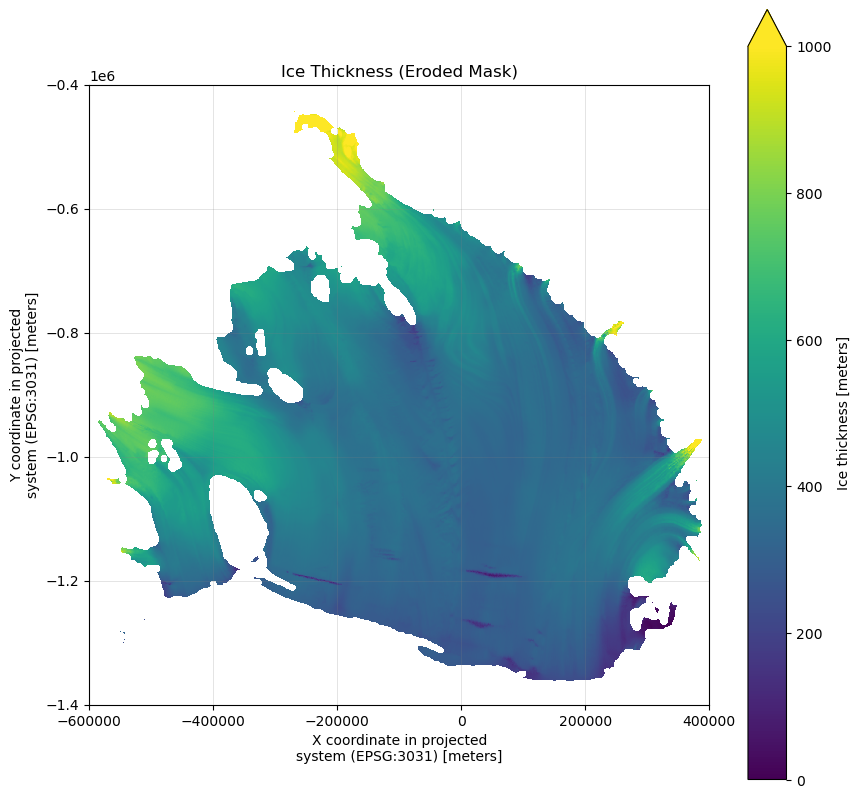

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

# Use eroded mask instead of the raw one
bm_ross.ice_thickness.where(tighter_ice_shelf_mask == 3).plot.pcolormesh(
    ax = ax, cmap = "viridis", vmin = 0, vmax = 1000
)

ax.set_title("Ice Thickness (Eroded Mask)")
ax.grid(True, which = "both", color = "grey", alpha = 0.3, linewidth = 0.5)
ax.set_aspect("equal")

plt.savefig("figures/ice_thickness_bedmap3_eroded_5km.png", dpi = 300, bbox_inches = "tight")
plt.show()